# Exploring Run Results with MLFlow

In [34]:
import mlflow
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

from pathlib import Path

figure_directory = Path('../docs/assets/images/')

In [35]:
client = mlflow.MlflowClient('../mlruns')

experiment = client.search_experiments()[0]
experiment_id = experiment.experiment_id

parent_runs = client.search_runs(
    experiment_id, 
    "tags.mlflow.source.name='file:///workspaces/telfer-ecg-heartbeat-categorization-task'",
    order_by=["start_time"])

last_parent_run = parent_runs[-1]


## Early stopping visualization

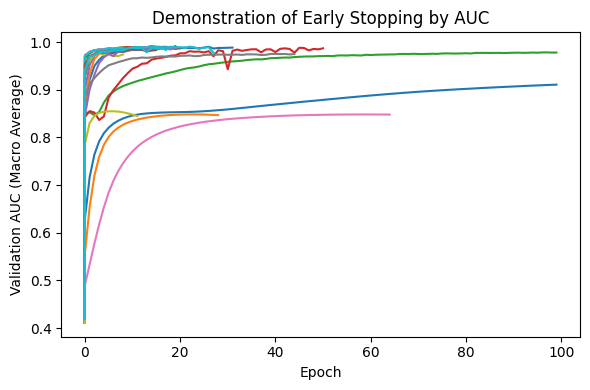

In [36]:

run_id = "2328622d8c974c95b3aaf7c12895828c"
runs = client.search_runs(
    [experiment_id],
    f"tags.mlflow.parentRunId='{last_parent_run.info.run_id}'",
)

plt.figure(figsize=(6,4))
for r in runs:
    history = client.get_metric_history(r.info.run_id, 'val_auroc')
    y = [i.value for i in history]
    x = [i.step for i in history]
    plt.plot(x, y, label=r.info.run_name)

plt.ylabel("Validation AUC (Macro Average)")
plt.xlabel("Epoch")
plt.title('Demonstration of Early Stopping by AUC')
plt.tight_layout()
plt.savefig(figure_directory / 'early_stopping_by_auc.png')

## Comparison between dataset results on all runs

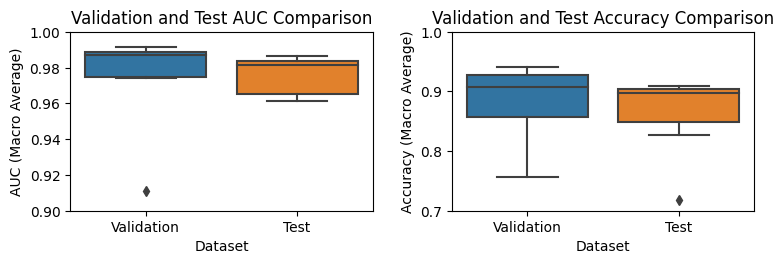

In [37]:
metrics_df = pd.DataFrame([r.data.metrics for r in runs])

def compare_datasets(df, col1_name, col2_name, ax=None):
    col1 = df[col1_name]
    col2 = df[col2_name]

    temp_df1 = pd.DataFrame(col1.values, columns=['Value'])
    temp_df1['Dataset'] = 'Validation'

    temp_df2 = pd.DataFrame(col2.values, columns=['Value'])
    temp_df2['Dataset'] = 'Test'

    temp_df = pd.concat([temp_df1, temp_df2], axis=0)
    sns.boxplot(data=temp_df, x='Dataset', y='Value', ax=ax)
    plt.tight_layout()

plt.figure(figsize=(8, 3))
gs = plt.GridSpec(1, 2)
ax = plt.subplot(gs[0])
compare_datasets(metrics_df, 'val_auroc', 'test_auroc', ax=ax)
plt.ylabel('AUC (Macro Average)')
plt.title('Validation and Test AUC Comparison')
plt.ylim([0.9, 1])

ax = plt.subplot(gs[1])
compare_datasets(metrics_df, 'val_accuracy', 'test_accuracy', ax=ax)
plt.ylabel('Accuracy (Macro Average)')
plt.title('Validation and Test Accuracy Comparison')
plt.tight_layout(pad=2.0)
plt.ylim([0.7, 1])
plt.savefig(figure_directory / "comparing_validation_vs_test_metrics.png")
plt.show()

## Best run parameters

In [38]:
params = ['weight_decay', 'lr', 'momentum', 'num_layers']

pd.Series({c: last_parent_run.data.tags[c] for c in params})


weight_decay    0.00013381067937488078
lr                0.005306323955804788
momentum            0.9695498105270768
num_layers                           4
dtype: object

## Best run comparison between dataset results

In [63]:
last_parent_run.data.tags

{'mlflow.source.name': 'file:///workspaces/telfer-ecg-heartbeat-categorization-task',
 'mlflow.source.git.repoURL': 'git@github.com:A-Telfer/telfer-ecg-heartbeat-categorization-task.git',
 'mlflow.project.env': 'conda',
 'lr': '0.005306323955804788',
 'num_layers': '4',
 'mlflow.project.backend': 'local',
 'momentum': '0.9695498105270768',
 'holdout_accuracy': 'tensor(0.8961)',
 'mlflow.runName': 'skittish-crow-502',
 'mlflow.gitRepoURL': 'git@github.com:A-Telfer/telfer-ecg-heartbeat-categorization-task.git',
 'mlflow.user': 'root',
 'best_run': 'de5c9c340d0c4b698ae55e7d2db3847b',
 'mlflow.project.entryPoint': 'main',
 'weight_decay': '0.00013381067937488078',
 'mlflow.source.type': 'PROJECT',
 'holdout_auroc': 'tensor(0.9833)'}

In [39]:
best_run_id = last_parent_run.data.tags['best_run']
best_run = client.get_run(best_run_id)

print('Train AUROC', best_run.data.metrics['train_auroc'])
print('Val AUROC', best_run.data.metrics['val_auroc'])
print('Test AUROC', best_run.data.metrics['test_auroc'])
print('Holdout AUROC', last_parent_run.data.tags['holdout_auroc'])

Train AUROC 0.9991170763969421
Val AUROC 0.9914817810058594
Test AUROC 0.9864406585693359
Holdout AUROC tensor(0.9833)


## Test Dataset 

In [40]:
best_run.data.metrics

{'train_f1': 0.9756200313568115,
 'val_accuracy': 0.9327149391174316,
 'test_accuracy_class4': 0.9502487778663635,
 'train_loss': 0.01461028028279543,
 'test_f1': 0.7925723791122437,
 'test_auroc': 0.9864406585693359,
 'val_f1': 0.7627555727958679,
 'train_auroc': 0.9991170763969421,
 'test_accuracy_class1': 0.7913669347763062,
 'val_auroc': 0.9914817810058594,
 'test_accuracy_class0': 0.9520918130874634,
 'train_accuracy': 0.9756200313568115,
 'test_accuracy_class2': 0.9116021990776062,
 'test_accuracy': 0.9062471389770508,
 'test_accuracy_class3': 0.9259259104728699}

In [47]:
best_run.info.artifact_uri

'file:///workspaces/telfer-ecg-heartbeat-categorization-task/mlruns/0/de5c9c340d0c4b698ae55e7d2db3847b/artifacts'

## Holdout Results

macro acc tensor(0.8961)
micro acc tensor(0.9445)
macro auroc tensor(0.9833)


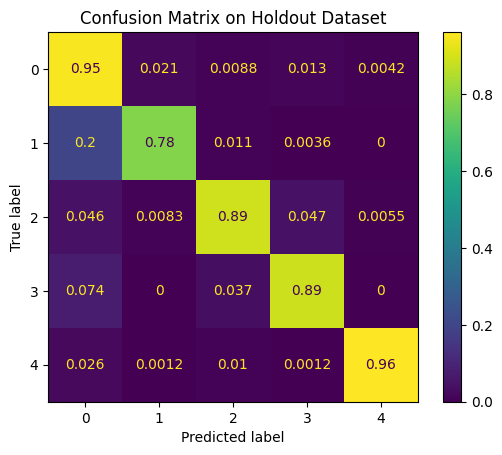

In [69]:
import torchmetrics
import torch

from torch.utils.data import DataLoader
from src.data.dataset import EcgDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

training_data = "../data/processed/"

model_uri = "../mlruns/0/{}/artifacts/linear_model".format(best_run.info.run_id)
model = mlflow.pytorch.load_model(model_uri)

holdout_datafile = Path(training_data) / "mitbih_holdout.csv"
holdout_df = pd.read_csv(holdout_datafile)

holdout_dataset = EcgDataset(holdout_df)
holdout_dataloader = DataLoader(
    holdout_dataset,
    batch_size=64,
)

with torch.no_grad():
    x_hat = []
    target = []
    for batch in holdout_dataloader:
        x, y = batch
        x_hat.append(model(x))
        target.append(y)

x_hat = torch.concat(x_hat)
preds = x_hat.argmax(axis=1)
target = torch.concat(target)

cm = confusion_matrix(target, preds, normalize='true')
ConfusionMatrixDisplay(cm).plot()

plt.title("Confusion Matrix on Holdout Dataset")
plt.savefig(figure_directory / 'confusion_matrix_holdout.png')

# Calculate macro accuracy
accuracy_score = torchmetrics.Accuracy(
    task="multiclass", num_classes=x_hat.shape[1], average="macro"
)(x_hat, target)
print('macro acc', accuracy_score)

accuracy_score = torchmetrics.Accuracy(
    task="multiclass", num_classes=x_hat.shape[1], average="micro"
)(x_hat, target)
print('micro acc', accuracy_score)

score = torchmetrics.AUROC(
    task="multiclass", num_classes=x_hat.shape[1], average="macro"
)(x_hat, target)
print('macro auroc', score)

## Testing Results

macro acc tensor(0.9062)
micro acc tensor(0.9450)


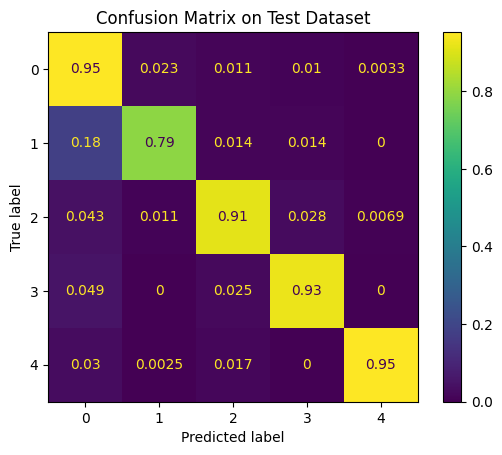

In [68]:
import torchmetrics
import torch

from torch.utils.data import DataLoader
from src.data.dataset import EcgDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

training_data = "../data/processed/"

model_uri = "../mlruns/0/{}/artifacts/linear_model".format(best_run.info.run_id)
model = mlflow.pytorch.load_model(model_uri)

test_datafile = Path(training_data) / "mitbih_test.csv"
test_df = pd.read_csv(test_datafile)

test_dataset = EcgDataset(test_df)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,
)

with torch.no_grad():
    x_hat = []
    target = []
    for batch in test_dataloader:
        x, y = batch
        x_hat.append(model(x))
        target.append(y)

x_hat = torch.concat(x_hat)
preds = x_hat.argmax(axis=1)
target = torch.concat(target)

cm = confusion_matrix(target, preds, normalize='true')
ConfusionMatrixDisplay(cm).plot()

plt.title("Confusion Matrix on Test Dataset")
plt.savefig(figure_directory / 'confusion_matrix_test.png')

# Calculate macro accuracy
accuracy_score = torchmetrics.Accuracy(
    task="multiclass", num_classes=x_hat.shape[1], average="macro"
)(x_hat, target)
print('macro acc', accuracy_score)

accuracy_score = torchmetrics.Accuracy(
    task="multiclass", num_classes=x_hat.shape[1], average="micro"
)(x_hat, target)
print('micro acc', accuracy_score)

score = torchmetrics.AUROC(
    task="multiclass", num_classes=x_hat.shape[1], average="macro"
)(x_hat, target)
print('macro auroc', score)